## Nuclear Masses

In [1]:
import scipy.stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import read as rd
import emcee
from tqdm import tqdm
import corner


### Bayesian Inference

In [2]:
df = rd.read()
N = np.array(df["N"])
Z = np.array(df["Z"])
BE = np.array(df["binding"])*10**(-3)
BE_err = np.array(df["unc_binding"])*10**(-3)

In [3]:
def model(a_v,a_s,a_c,a_a,N,Z):
    A = N + Z
    return (a_v*A - a_s*A**(2/3) - a_c*Z*(Z-1)/(A**(1/3)) - a_a*((N-Z)**2)/A)/A

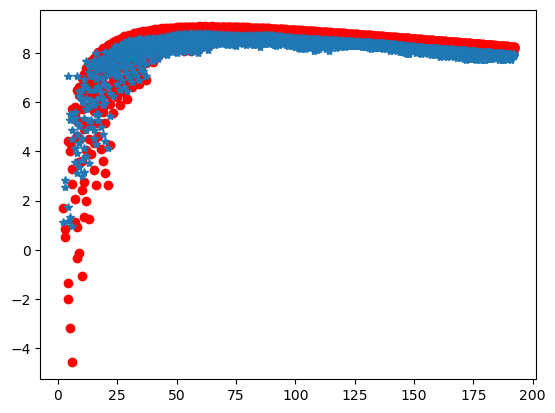

In [4]:
A = N + Z
n_points = 2000
plt.errorbar(A[:n_points], BE[:n_points], BE_err[:n_points], marker = "*" , ls = " ")

a_v_th = 16
a_s_th = 18
a_c_th = 0.7
a_a_th = 24

BE_th = model(a_v_th, a_s_th, a_c_th, a_a_th, N, Z)
plt.scatter(A[:n_points], BE_th[:n_points], color = 'red')

## EMCEE

In [14]:
# Parameters
param_names = ['a_v', 'a_s', 'a_c', 'a_a']

def loglikelihood(params):
    (a_v, a_s, a_c, a_a) = params
    log_like = -np.sum(((model(a_v, a_s, a_c, a_a, N, Z) - BE)/BE_err)**2 + np.log(2*np.pi*BE_err**2)) / 2. 
    return log_like
    
def prior(params):
    (a_v, a_s, a_c, a_a) = params

    if (
        0 < a_v < 50 and
        0 < a_s < 50 and
        0 < a_c < 3 and
        0 < a_a < 40
    ):
        return 0

    return -np.inf

def log_post(params):
    if not np.isfinite(prior(params)):
        return -np.inf
    return loglikelihood(params) + prior(params)

In [18]:
ndim = 4
nwalkers = 30

p0 = np.array([0, 0, 0, 0]) + np.random.rand(nwalkers, ndim) * np.array(
    [50, 50, 3, 40]
)

In [19]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_post, args=())
sampler.run_mcmc(p0, 5000, progress=True)

  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [00:53<00:00, 92.64it/s] 


State([[15.25509952 16.13114282  0.76577049 11.17317259]
 [15.25509975 16.13114337  0.76577054 11.17317171]
 [15.25509965 16.13114297  0.76577052 11.17317293]
 [15.2550995  16.13114274  0.7657705  11.1731721 ]
 [15.2550999  16.13114343  0.76577057 11.17317149]
 [15.25509919 16.13114224  0.76577043 11.17317562]
 [15.2550997  16.13114298  0.76577053 11.17317506]
 [15.25509981 16.1311433   0.76577053 11.17317401]
 [15.25509974 16.13114325  0.76577053 11.17317251]
 [15.2550994  16.13114251  0.76577049 11.17317375]
 [15.25509947 16.13114274  0.76577051 11.17317104]
 [15.25510024 16.13114432  0.76577061 11.1731716 ]
 [15.25509917 16.13114218  0.76577044 11.17317507]
 [15.25510005 16.13114364  0.76577058 11.17317474]
 [15.25509942 16.1311426   0.76577051 11.17317273]
 [15.25509954 16.13114292  0.76577049 11.17317475]
 [15.25510003 16.13114374  0.76577061 11.17317113]
 [15.25509922 16.13114222  0.76577044 11.17317399]
 [15.2550995  16.13114295  0.7657705  11.17317364]
 [15.25509961 16.131143  

Text(0.5, 0, 'step number')

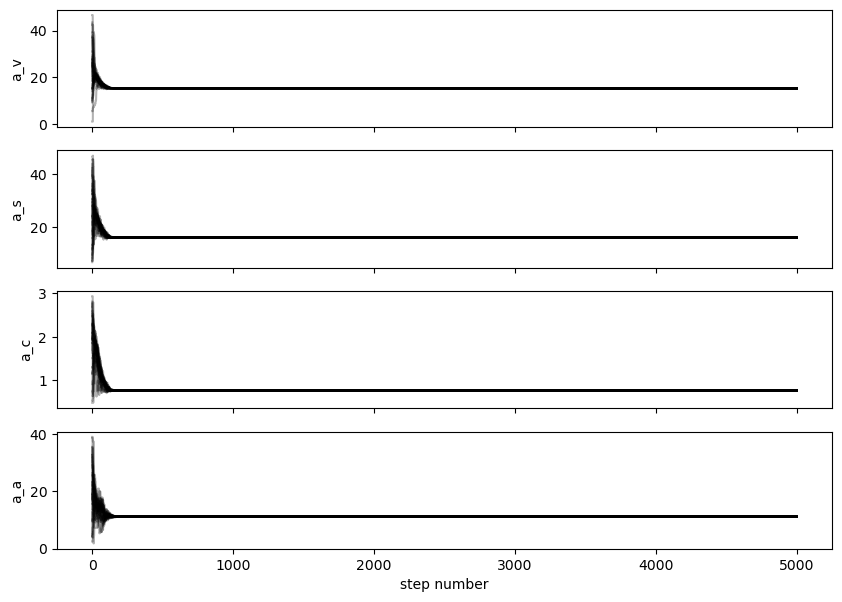

In [20]:
fig, axs = plt.subplots(4, 1, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()

for index, ax in enumerate(axs):
    ax.plot(samples[:, :, index], "k", alpha=0.3)
    ax.set_ylabel(["a_v", "a_s", "a_c", "a_a"][index])

axs[-1].set_xlabel("step number")

Quantiles:
[(0.025, np.float64(15.255099118380096)), (0.5, np.float64(15.255099726001006)), (0.975, np.float64(15.255100348701736))]
Quantiles:
[(0.025, np.float64(16.13114209597622)), (0.5, np.float64(16.131143195555595)), (0.975, np.float64(16.131144316422734))]
Quantiles:
[(0.025, np.float64(0.7657704240830868)), (0.5, np.float64(0.7657705347204227)), (0.975, np.float64(0.7657706478775403))]
Quantiles:
[(0.025, np.float64(11.173169879388604)), (0.5, np.float64(11.173172902425705)), (0.975, np.float64(11.173175909458564))]


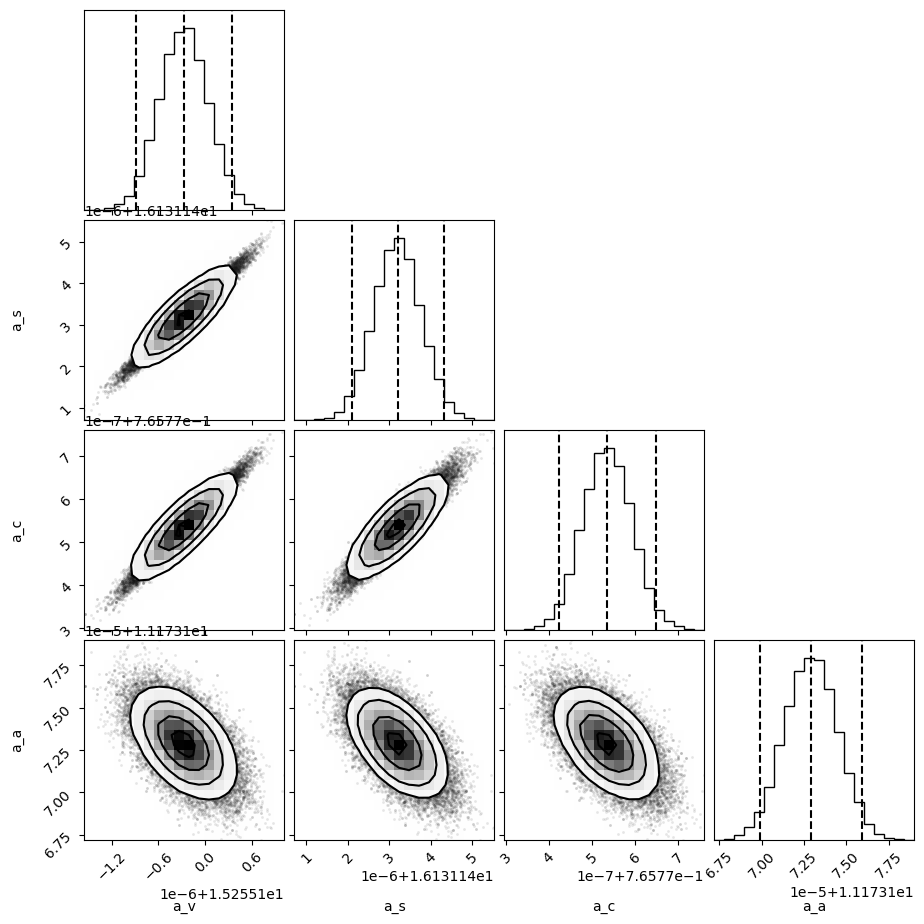

In [21]:
flat_samples = sampler.get_chain(discard=1000, thin=3, flat=True)
fig = corner.corner(flat_samples, labels=["a_v", "a_s", "a_c", "a_a"], verbose= True, plot_contours=True, quantiles=[0.025, 0.5, 0.975], smooth=True)

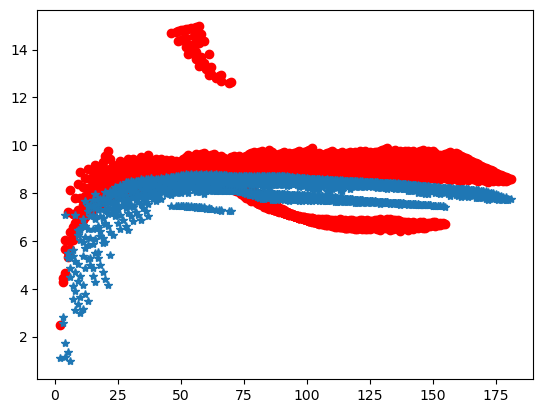

In [82]:
A = N + Z
n_points = 4000
plt.errorbar(A[:n_points], BE[:n_points], BE_err[:n_points], marker = "*" , ls = " ")

a_v_best = 13.6
a_s_best = 14
a_c_best = 0.4
a_a_best = -5

BE_best = model(a_v_best, a_s_best, a_c_best, a_a_best, N, Z)
plt.scatter(A[:n_points], BE_best[:n_points], color = 'red')